In [2]:
%cd ..

/home/jhkim/workspace/lrquant


/home/jhkim/workspace/lrquant/.venv/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [18]:
import gc
import os
import typing

import numpy as np
import pandas as pd
import torch
from tqdm import tqdm

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.style as mplstyle

mplstyle.use("fast")

from IPython.display import display

if "CUDA_VISIBLE_DEVICES" in os.environ:
    print(os.environ["CUDA_VISIBLE_DEVICES"])

torch.set_printoptions(precision=4, sci_mode=False)

0,1


In [50]:
from models.LMClass import LMClass

lm = LMClass("./huggingface/llama-2-7b-hf")


from datautils import get_loaders

dataloader, _ = get_loaders(
    name="wikitext2",
    nsamples=128,
    seed=2,
    model=lm.model_name,
    seqlen=lm.seqlen,
    cache_dir=f"./cache/wikitext2_1_2/dataloader.cache",
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

vocab size:  32000
Loading train from ./cache/wikitext2_1_2/dataloader.cache


In [51]:
dataloader_part = dataloader[:1]

layer_all_inps = torch.zeros(
    (len(dataloader_part), 32, 2048, 4096), dtype=torch.float32
)

with torch.no_grad():
    for batch_idx, batch in tqdm(enumerate(dataloader_part)):
        for layer_index, layer in enumerate(lm.model.model.layers):

            def layer_hook(batch_index, layer_index):
                def _fn(module, input: tuple[torch.Tensor], output):
                    out_token_magnitudes = output[0][0].square().mean(dim=1)
                    print(
                        batch_index,
                        layer_index,
                        output[0][0].shape,
                        output[0][0].abs().topk(5).values,
                        out_token_magnitudes.sort(descending=True).values,
                    )
                    layer_all_inps[batch_index, layer_index] = (
                        output[0][0].detach().clone()
                    )

                return _fn

            layer._forward_hooks.clear()
            layer.register_forward_hook(layer_hook(batch_idx, layer_index))

        lm.model.eval()
        lm.model.to(lm.device)
        lm.model(batch[0].to(lm.device))
        lm.model.cpu()
        gc.collect()
        torch.cuda.empty_cache()

0it [00:00, ?it/s]

0 0 torch.Size([2048, 4096]) tensor([[0.8525, 0.6582, 0.4890, 0.4175, 0.3965],
        [1.5449, 1.5010, 0.3130, 0.2810, 0.1371],
        [1.8750, 1.7295, 0.3628, 0.2742, 0.2263],
        ...,
        [1.0098, 0.9160, 0.2180, 0.2180, 0.1641],
        [1.1367, 1.0166, 0.2620, 0.2103, 0.1593],
        [0.6553, 0.2856, 0.2520, 0.2360, 0.1997]], device='cuda:0',
       dtype=torch.float16) tensor([0.0059, 0.0025, 0.0022,  ..., 0.0004, 0.0004, 0.0004], device='cuda:0',
       dtype=torch.float16)
0 1 torch.Size([2048, 4096]) tensor([[  712.0000,   425.2500,    33.9688,    29.2344,    17.7500],
        [    0.4214,     0.3804,     0.3779,     0.3391,     0.2798],
        [    0.6948,     0.6738,     0.5356,     0.4800,     0.4697],
        ...,
        [    0.7759,     0.6943,     0.4829,     0.4543,     0.4136],
        [    0.9575,     0.9341,     0.6206,     0.5732,     0.5146],
        [    0.5688,     0.5400,     0.4834,     0.4805,     0.4316]],
       device='cuda:0', dtype=torch.float

1it [00:10, 10.48s/it]


In [52]:
layer_inps = layer_all_inps[0]
layer_all_inps[0][1].abs().topk(5).values

tensor([[  712.0000,   425.2500,    33.9688,    29.2344,    17.7500],
        [    0.4214,     0.3804,     0.3779,     0.3391,     0.2798],
        [    0.6948,     0.6738,     0.5356,     0.4800,     0.4697],
        ...,
        [    0.7759,     0.6943,     0.4829,     0.4543,     0.4136],
        [    0.9575,     0.9341,     0.6206,     0.5732,     0.5146],
        [    0.5688,     0.5400,     0.4834,     0.4805,     0.4316]])

## 두 가지 종류의 outlier
### outlier token 
- 전체 input sequence에서 유독 높은 vector magnitude들을 가지는 sequence가 있음
- 대부분의 입력 데이터에서 0번 sequence의 token vector magnitude가 큰 값을 가짐
    - <bos> 토큰?
- 적어도 llama-2-7b 모델에서는 하나 이상의 0번이 아닌 outlier token이 존재함
    - 몇 가지 입력 데이터를 확인해본 결과 "."이거나 "\n" 토큰이었음
- 이 outlier token은 여러 outlier component들을 가지지만, 대부분의 components들은 여전히 0에 가까운 값을 가짐
    - 몇 개의 극단적인 outlier component들이 존재
        - dimension

In [12]:
magnitudes = layer_inps.square().mean(dim=2)  # [32, 2048]
print(magnitudes.shape)
topk = magnitudes.topk(5, dim=1)
display(pd.DataFrame([list(zip(topk.values[i], topk.indices[i])) for i in range(32)]))

torch.Size([32, 2048])


,0,1,2,3,4
0,"(tensor(0.0059), tensor(23))","(tensor(0.0025), tensor(2))","(tensor(0.0022), tensor(10))","(tensor(0.0021), tensor(71))","(tensor(0.0021), tensor(0))"
1,"(tensor(1992.3059), tensor(23))","(tensor(169.0264), tensor(0))","(tensor(0.0033), tensor(526))","(tensor(0.0032), tensor(21))","(tensor(0.0032), tensor(1491))"
2,"(tensor(1998.9679), tensor(23))","(tensor(171.1648), tensor(0))","(tensor(0.0062), tensor(1775))","(tensor(0.0060), tensor(1456))","(tensor(0.0060), tensor(472))"
3,"(tensor(1998.8000), tensor(23))","(tensor(171.1653), tensor(0))","(tensor(0.0116), tensor(34))","(tensor(0.0115), tensor(1979))","(tensor(0.0107), tensor(904))"
4,"(tensor(2014.1641), tensor(23))","(tensor(174.4608), tensor(0))","(tensor(0.0195), tensor(904))","(tensor(0.0187), tensor(1777))","(tensor(0.0186), tensor(1769))"
5,"(tensor(2014.1191), tensor(23))","(tensor(174.4566), tensor(0))","(tensor(0.0282), tensor(904))","(tensor(0.0274), tensor(1634))","(tensor(0.0271), tensor(1))"
6,"(tensor(2014.0920), tensor(23))","(tensor(174.4552), tensor(0))","(tensor(0.0540), tensor(154))","(tensor(0.0532), tensor(980))","(tensor(0.0443), tensor(531))"
7,"(tensor(2014.1165), tensor(23))","(tensor(174.4440), tensor(0))","(tensor(0.0852), tensor(154))","(tensor(0.0650), tensor(1203))","(tensor(0.0643), tensor(1730))"
8,"(tensor(2013.9060), tensor(23))","(tensor(174.4408), tensor(0))","(tensor(0.1777), tensor(154))","(tensor(0.1619), tensor(495))","(tensor(0.1182), tensor(980))"
9,"(tensor(2013.8350), tensor(23))","(tensor(174.4154), tensor(0))","(tensor(0.2289), tensor(154))","(tensor(0.1808), tensor(495))","(tensor(0.1388), tensor(980))"


In [16]:
layer_index = 2
display(pd.DataFrame(layer_inps[layer_index, 0, :].abs()).sort_values(0, ascending=False).T)
display(pd.DataFrame(layer_inps[layer_index, 113, :].abs()).sort_values(0, ascending=False).T)

print(dataloader[0][0][0])
print(repr(lm.tokenizer.decode(dataloader[0][0][0])))
print(repr(lm.tokenizer.decode(dataloader[0][0][0][113])))
print(repr(lm.tokenizer.decode(dataloader[0][0][0][111:115])))
# print(repr(lm.tokenizer.decode(dataloader[52][0][0][225:229])))

,2533,1415,1512,1076,2298,339,3431,2789,2158,3135,...,373,2400,3912,2057,2245,1151,3549,1105,591,1241
0,716.5,428.0,34.46875,29.75,17.578125,14.9375,14.648438,14.304688,12.59375,11.0625,...,0.000488,0.000458,0.000401,0.000366,0.000343,0.000305,0.000305,0.000183,0.000156,0.000076


,1793,2298,257,1512,339,2789,3135,2522,490,1076,...,1233,381,726,3186,396,1226,285,1989,2419,427
0,0.733398,0.698242,0.696289,0.665039,0.570312,0.537598,0.537598,0.483643,0.482178,0.429688,...,0.000122,0.000114,0.000092,0.000092,0.000084,0.000057,0.000053,0.000038,0.000031,0.000029


tensor([[ 1539,  1338,  1919,  ...,   411,   385, 15899]])
'metals , such as indium antimonide ( InSb ) and silver antimonide ( Ag \n\n\n 3Sb ) . The alkali metal and zinc antimonides , such as Na3Sb and Zn3Sb2 , are more reactive . Treating these antimonides with acid produces the unstable gas stibine , SbH \n\n\n 3 : \n\n\n Sb3 − + 3 H + → SbH \n\n\n 3 \n\n\n Stibine can also be produced by treating Sb3 + salts with hydride reagents such as sodium borohydride.Stibine decomposes spontaneously at room temperature . Because stibine has a positive heat of formation , it is thermodynamically unstable and thus antimony does not react with hydrogen directly . \n\n\n Organoantimony compounds are typically prepared by alkylation of antimony halides with Grignard reagents . A large variety of compounds are known with both Sb ( III ) and Sb ( V ) centers , including mixed chloro @-@ organic derivatives , anions , and cations . Examples include Sb ( C6H5 ) 3 ( triphenylstibine ) , Sb2 ( C6H5 ) 4

In [7]:
display(pd.DataFrame(layer_inps[:, 113, (2533, 1415, 1512)].abs().sort().values, columns=["2533", "1415", "1512"]).T)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
2533,0.000166,0.066895,170.375,170.0,167.875,166.875,165.375,165.0,166.0,165.375,...,195.5,202.25,201.125,196.25,195.0,193.75,195.375,194.625,182.25,35.625
1415,0.005524,0.178467,1623.000,1626.0,1626.000,1631.000,1631.000,1631.0,1631.0,1631.000,...,1631.0,1631.00,1631.000,1631.00,1631.0,1631.00,1631.000,1631.000,1606.00,69.000
1512,0.024292,0.981445,2754.000,2758.0,2758.000,2768.000,2768.000,2768.0,2768.0,2768.000,...,2772.0,2772.00,2772.000,2772.00,2772.0,2772.00,2772.000,2772.000,2724.00,138.000


### outlier channel
- layer에는 유독 높은 값들을 가지는 channel들이 존재함
    - 여기서 channel은 token vector component의 index를 의미함
        - 더 좋은 표현?
- outlier channel의 대부분의 vector component들이 vector 내에서 이상치로 나타남

In [ ]:
layer_inps_mean = layer_inps.mean(dim=2, keepdim=True)
layer_inps_std = layer_inps.std(dim=2, keepdim=True)
layer_inps_standardized = (layer_inps - layer_inps_mean) / layer_inps_std

def display_channel(channel_index):
    print("Sqared Mean:", layer_inps[layer_index, :, channel_index].square().mean(dim=0), "Standardized Sqared Mean:", layer_inps_standardized[layer_index, :, channel_index].square().mean(dim=0))
    display(pd.DataFrame(layer_inps[layer_index, :, channel_index].abs()).sort_values(0, ascending=False).T)
    
# 전체적으로 outlier인 channel
display_channel(1512)
# display_channel(2298)

# 한두개의 component만 극단적으로 큰 channel
display_channel(2533)
# display_channel(1415)


Sqared Mean: tensor(15.5762) Standardized Sqared Mean: tensor(0.9995)


,113,0,872,2033,590,1072,2013,1567,905,1625,...,1850,102,29,713,1416,58,63,33,90,75
0,170.375,39.0,1.896484,1.871094,1.859375,1.810547,1.772461,1.748047,1.720703,1.708008,...,0.137817,0.124756,0.115234,0.108276,0.101318,0.099609,0.080078,0.030457,0.016479,0.001953


Sqared Mean: tensor(3980.9758) Standardized Sqared Mean: tensor(0.9995)


,113,0,1919,1891,1939,757,1938,1975,1720,1930,...,528,100,537,691,379,514,1998,118,1227,1732
0,2754.0,754.0,0.202393,0.194214,0.177124,0.164307,0.151367,0.149658,0.148315,0.145386,...,0.000366,0.000366,0.000366,0.000351,0.000259,0.000229,0.000175,0.000137,0.000092,0.000092


In [10]:
display(pd.DataFrame(layer_inps[:, :, 2533].abs()).T)
display(pd.DataFrame(layer_inps[:, (0,113), 2533].abs()).T)

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.000759,0.350586,754.000000,758.500000,758.500000,766.000000,766.000000,766.000000,766.000000,766.000000,...,772.000000,772.500000,773.000000,773.000000,772.500000,772.500000,772.000000,771.000000,765.500000,237.000000
1,0.005371,0.229492,0.116699,0.245605,0.364502,0.697754,1.172852,1.472656,1.678711,1.897461,...,14.664062,15.617188,16.203125,17.562500,17.906250,18.046875,17.421875,16.796875,15.578125,7.550781
2,0.003845,0.032684,0.009064,0.117798,0.263916,0.341309,0.636719,0.782227,1.051758,1.296875,...,10.750000,11.820312,12.515625,14.492188,15.414062,15.601562,14.773438,14.390625,13.437500,6.480469
3,0.000197,0.003334,0.040710,0.063477,0.186035,0.216309,0.468750,0.708008,0.898926,1.162109,...,10.867188,11.929688,12.609375,13.257812,13.468750,14.414062,13.843750,13.406250,11.421875,5.359375
4,0.000759,0.078735,0.023499,0.078735,0.153320,0.194214,0.459961,0.582520,0.713867,0.931641,...,14.453125,15.742188,16.718750,19.062500,19.640625,20.390625,19.703125,19.156250,17.859375,9.781250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2043,0.003113,0.093079,0.038757,0.030075,0.127319,0.118408,0.141235,0.105469,0.072083,0.166504,...,1.139648,0.812012,0.829590,0.790527,0.980469,0.925781,1.142578,1.537109,0.894531,2.628906
2044,0.001167,0.089722,0.037445,0.044434,0.047546,0.007324,0.009613,0.077942,0.278564,0.247803,...,0.953125,0.981445,1.129883,1.154297,1.148438,1.240234,1.701172,2.421875,1.971680,0.445312
2045,0.003021,0.097107,0.055481,0.066345,0.169678,0.245117,0.281494,0.339111,0.370605,0.608887,...,1.959961,3.033203,3.085938,4.164062,3.169922,3.929688,3.843750,3.589844,4.078125,4.351562
2046,0.000748,0.055847,0.097107,0.038208,0.132324,0.076660,0.156006,0.175659,0.269043,0.364990,...,3.126953,3.781250,4.875000,5.578125,4.480469,4.621094,4.261719,3.406250,2.953125,0.474609


,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.000759,0.350586,754.0,758.5,758.5,766.0,766.0,766.0,766.0,766.0,...,772.0,772.5,773.0,773.0,772.5,772.5,772.0,771.0,765.5,237.0
1,0.005524,0.066895,2754.0,2758.0,2758.0,2768.0,2768.0,2768.0,2768.0,2768.0,...,2772.0,2772.0,2772.0,2772.0,2772.0,2772.0,2772.0,2772.0,2724.0,138.0


In [ ]:
layer_inps_mean = layer_inps.mean(dim=2, keepdim=True)
layer_inps_std = layer_inps.std(dim=2, keepdim=True)
layer_inps_standardized = (layer_inps - layer_inps_mean) / layer_inps_std

layer_index = 2

df = pd.DataFrame()
df["std_magnitude"] = layer_inps_standardized.square().mean(dim=1)[layer_index]
df["magnitude"] = layer_inps.square().mean(dim=1)[layer_index]

display(df.sort_values("std_magnitude", ascending=False).T)
display(df.sort_values("magnitude", ascending=False).T)

,2281,456,714,2582,1812,3919,1733,2667,1416,545,...,366,290,1151,3083,905,563,3640,3178,3568,2100
std_magnitude,0.999512,0.999512,0.999512,0.999512,0.999512,0.999512,0.999512,0.999512,0.999512,0.999512,...,0.999511,0.999511,0.999511,0.999511,0.999511,0.999511,0.999511,0.999511,0.999511,0.999511
magnitude,0.017211,0.003044,0.003690,0.009358,0.002119,0.004441,0.001782,0.002723,0.001829,0.004165,...,0.002896,0.004974,0.005833,0.001916,0.003003,0.003331,0.003710,0.006088,0.003830,0.001646


,2533,1415,1512,2298,3431,2168,3135,339,2393,1076,...,3703,2319,2451,170,3923,1559,1301,3520,1951,1744
std_magnitude,0.999512,0.999512,0.999512,0.999512,0.999512,0.999512,0.999512,0.999512,0.999512,0.999512,...,0.999512,0.999512,0.999512,0.999512,0.999512,0.999512,0.999512,0.999512,0.999512,0.999512
magnitude,3980.975342,1384.744507,15.576243,5.024303,2.137006,1.902065,1.855412,1.798153,1.525816,1.072778,...,0.000691,0.000690,0.000686,0.000684,0.000674,0.000666,0.000659,0.000654,0.000640,0.000635


## Todo
- activation outlier 관련 논문 보기
    - https://arxiv.org/abs/2309.15531
    - https://arxiv.org/abs/2310.08041

- decoder layer의 각 컴포넌트별로 outlier 확인하기
  - 실제로 코딩하려면 decoder 내부 컴포넌트끼리의 연산에 적용시켜야 할 것 같음

- outlier token과 outlier channel을 구분하는 방법

In [12]:
def omit_outliers1(values: torch.Tensor, *, threshold: float=0.1):
    mean_prev = None
    index = 0
    for i in range(values.shape[0]):
        mean = values[i:].mean(dim=0)
        if mean_prev is not None: 
            # print(mean_prev - mean)
            if mean_prev - mean > threshold:
                index = i+1
                break
            
        mean_prev = mean
    return index

def omit_outliers2(values: torch.Tensor, *, threshold: float=0.1):
    mean_prev = None
    index = 0
    for i in range(values.shape[0]):
        sum = values[:i+1].sum(dim=0)
        mean = sum / (i+1)
        if mean_prev is not None: 
            if (mean_prev-mean).abs() > threshold:
                index = i+1
                break
            
        mean_prev = mean
    return index

In [14]:
layer_index = 2
# 1512, 2298, 1076
# 2533, 1415
outlier_channel = layer_inps[layer_index, :, 1512].abs().sort(dim=0, descending=True)
index = omit_outliers2(outlier_channel.values)
outlier_indices = outlier_channel.indices[:index]
print("Index:", index, outlier_indices)
display(pd.DataFrame(outlier_channel.values[index:]).T)

# outlier_channel.values[index:].

Index: 2 tensor([113,   0])


,0,1,2,3,4,5,6,7,8,9,...,2036,2037,2038,2039,2040,2041,2042,2043,2044,2045
0,1.896484,1.871094,1.859375,1.810547,1.772461,1.748047,1.720703,1.708008,1.692383,1.675781,...,0.137817,0.124756,0.115234,0.108276,0.101318,0.099609,0.080078,0.030457,0.016479,0.001953


In [ ]:
layer_index = 0
channel_mags = layer_inps_standardized.abs().mean(dim=1)[layer_index].sort(dim=0, descending=True)
index = omit_outliers2(channel_mags.values)
outlier_indices = channel_mags.indices[:index]
print("Index:", index, outlier_indices)
display(pd.DataFrame(channel_mags))

Index: 2 tensor([1512, 2298])


,0,1,2,3,4,5,6,7,8,9,...,4086,4087,4088,4089,4090,4091,4092,4093,4094,4095
0,tensor(18.2895),tensor(13.6530),tensor(10.2918),tensor(8.3807),tensor(8.2705),tensor(7.9027),tensor(7.0174),tensor(6.2910),tensor(6.2295),tensor(6.0052),...,tensor(0.4510),tensor(0.4496),tensor(0.4488),tensor(0.4476),tensor(0.4474),tensor(0.4434),tensor(0.4422),tensor(0.4401),tensor(0.4401),tensor(0.4384)
1,tensor(1512),tensor(2298),tensor(1076),tensor(3431),tensor(2393),tensor(3135),tensor(257),tensor(339),tensor(490),tensor(2789),...,tensor(2127),tensor(3156),tensor(473),tensor(3262),tensor(1758),tensor(752),tensor(3759),tensor(128),tensor(1951),tensor(2715)


In [ ]:
torch.save(layer_inps[2], "layer_inps.pt")

In [ ]:
dd = torch.load("layer_inps.pt")
dd

tensor([[ 0.0840, -0.7900,  0.0535,  ..., -0.1202, -0.1425,  0.0779],
        [ 0.0284,  0.0437,  0.0077,  ..., -0.0048,  0.0084,  0.0276],
        [-0.0130,  0.0528,  0.0924,  ...,  0.0028,  0.0343,  0.0456],
        ...,
        [-0.0132,  0.0287,  0.0182,  ...,  0.0069,  0.0234,  0.0186],
        [ 0.0070,  0.0368, -0.0491,  ...,  0.0278, -0.0135, -0.0294],
        [ 0.0287,  0.0312, -0.0296,  ...,  0.0105,  0.0010, -0.0268]])

tensor([18.2895, 13.6530, 10.2918,  ...,  0.4401,  0.4401,  0.4384])

tensor([87702512.0000, 850016.7500, 29490.6387,  ...,     1.5529,     1.5528,
            1.5502])

tensor([320388.1250, 12881.4854,  1253.5712,  ...,     1.3567,     1.3567,
            1.3551])

tensor([3.9596, 3.6846, 3.4241,  ..., 1.3647, 1.3647, 1.3635])

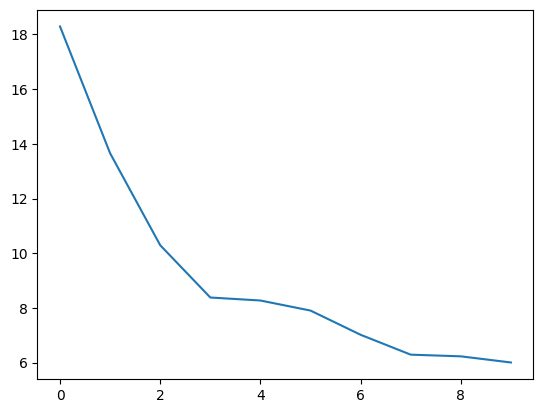

tensor([  386.9820,   254.9887,   121.0999,  ...,     0.3317,     0.3310,
            0.3245])

tensor([   inf,    inf,    inf,  ..., 1.3933, 1.3924, 1.3834])

tensor([       inf,        inf, 2849033632070193582856577357929512960.0000,  ...,     1.2585,     1.2579,
            1.2523])

tensor([6.9610, 6.5451, 5.8048,  ..., 1.2864, 1.2859, 1.2811])

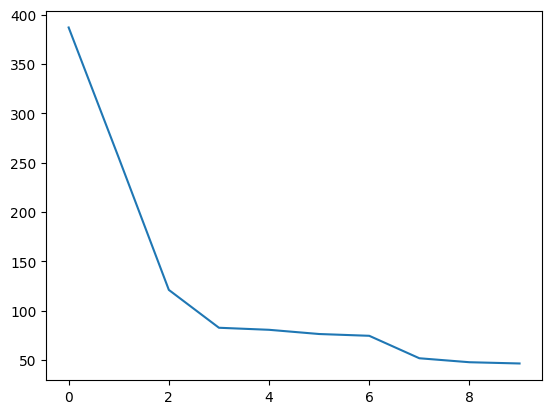

In [89]:
from matplotlib import pyplot as plt

d = (
    layer_inps_standardized.abs()
    .mean(dim=1)[layer_index]
    .sort(dim=0, descending=True)
    .values
)
display(d, d.exp(), d.exp2(), (d+1).log()+1)
plt.plot(d[:10].cpu().numpy())
plt.show()

d = (
    layer_inps_standardized.square()
    .mean(dim=1)[layer_index]
    .sort(dim=0, descending=True)
    .values
)

display(d, d.exp(), d.exp2(), (d+1).log()+1)
plt.plot(d[:10].cpu().numpy())
plt.show()